In [1]:
from PINNs import Bound, PhysicsBound, PINN, NVS, NetworkTrainer, Visualization
import torch
import matplotlib.pyplot as plt

## Define Physical Space

Define physical bound

In [2]:
bound_list = []
def func1(x):
    return 1*torch.ones_like(x)
bound_list.append(Bound([0,10], func1, True))
def func2(x):
    return 0*torch.ones_like(x)
bound_list.append(Bound([0,10], func2, False))


def func4(y):
    return 0*torch.ones_like(y)
bound_list.append(Bound([0.00001,0.99999], func4, False, ref_axis='y'))
def func5(y):
    return 10*torch.ones_like(y)
bound_list.append(Bound([0,1], func5, True, ref_axis='y'))

Plot Physical bound

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


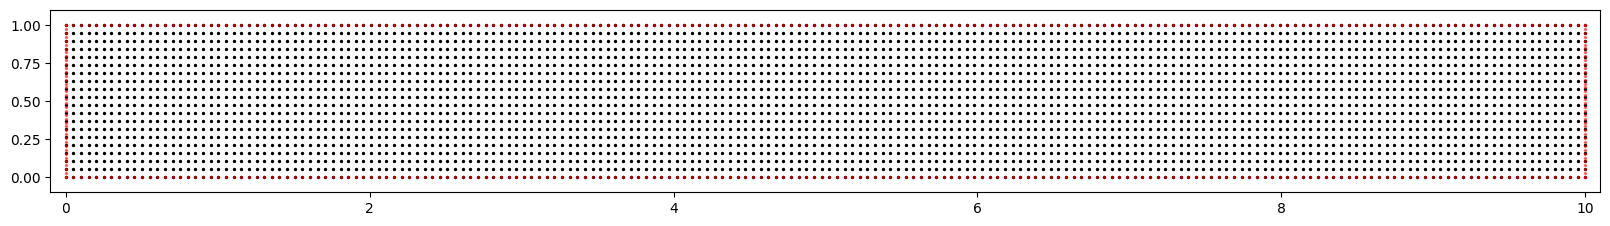

In [3]:
X, Y = Bound.sampling_area(bound_list, [200,20], [0,10], [0,1])

sampling_resolution_list = [
    200,
    200,
    40,
    40,
]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=2, color='black')
for i,bound in enumerate(bound_list):
    x,y = bound.sampling_line(sampling_resolution_list[i])
    plt.scatter(x,y,s=2, color='red', alpha=0.5)
plt.xlim(-0.1,10.1)
plt.ylim(-0.1,1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [4]:
physics_cond_list = [
    {'u': 0.0, 'v': 0.0},  # func1: top wall (y=1) -> No-slip
    {'u': 0.0, 'v': 0.0},  # func2: bottom wall (y=0) -> No-slip
    {'u': 0.1, 'v': 0.0},  # func3: inlet (x=0) -> Uniform inflow,
    {'p': 0.0}             # func4: outlet (x=2) -> Zero pressure
]
boundary_conditions_list = []
for i, bound in enumerate(bound_list):
    boundary_conditions_list.append(PhysicsBound.define_boundary_condition(bound, physics_cond_list[i]))
area_physics_bound = PhysicsBound.define_pde_area(bound_list=bound_list, sampling_range_x=[0,10], sampling_range_y=[0,1], PDE_class=NVS())

### Sampling points

In [5]:
sampling_resolution_list = [
    200,
    200,
    40,
    40,
]

def uniform_sampling():
    for i,bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i])
    area_physics_bound.sampling_collocation_points(100)

def random_sampling():
    for i,bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i],True)
    area_physics_bound.sampling_collocation_points(100,True)

## Define Physics

In [6]:
model0 = PINN(width=64, length=4, is_steady=True)

In [7]:
loss_fn = torch.nn.MSELoss()
def calc_loss(model):

    #respawn the collocation point
    random_sampling()

    #bc_loss
    bc_loss = 0
    for i, bc in enumerate(boundary_conditions_list):
        weight = 1
        if i==2:
            weight = 2
        bc_loss += weight*bc.calc_loss(model, loss_fn)

    #pde_loss
    pde_loss = area_physics_bound.calc_loss(model)

    #total_loss
    total_loss = bc_loss + 3*pde_loss
    
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [8]:
model1 = NetworkTrainer.train_adam(model=model0, calc_loss=calc_loss, learning_rate=0.001, epochs=1500**0, print_every=100)

epoch 1, total_loss: 0.13010, bc_loss: 0.12800, pde_loss: 0.00070


In [9]:
sampling_resolution_list = [
    3200,
    3200,
    640,
    640,
]

def uniform_sampling():
    for i,bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i])
    area_physics_bound.sampling_collocation_points(100)

def random_sampling():
    for i,bc in enumerate(boundary_conditions_list):
        bc.sampling_collocation_points(sampling_resolution_list[i],True)
    area_physics_bound.sampling_collocation_points(100,True)

In [10]:
model2 = NetworkTrainer.train_adam(model=model1, calc_loss=calc_loss, learning_rate=0.0005, epochs=2000**0, print_every=100)

epoch 2, total_loss: 0.06710, bc_loss: 0.06666, pde_loss: 0.00015


## Visualization with built-in tools

In [11]:
visual_model = Visualization(area_physics_bound,model2)
visual_model.sampling_plot_points(400,40)
visual_model.process_model()

cmap_dict = {'p':'RdBu'}

fig_output = visual_model.colorplot_all()

## Visualization without tools

In [12]:
import numpy as np
import PINNs
area_physics_bound.sampling_collocation_points([400,40])
area_physics_bound.process_model(model2)
area_physics_bound.process_pde()
X,Y,T = area_physics_bound.model_inputs.values()
U,V,P = area_physics_bound.model_outputs.values()
residual = area_physics_bound.PDE.calc_residual_sum()
X,Y,U,V,P,residual = PINNs.torch_to_numpy(X,Y,U,V,P,residual)
V_size = np.sqrt(U**2+V**2)


In [13]:
print(P.shape,X.shape, residual.shape)

(16000, 1) (16000, 1) (16000, 1)


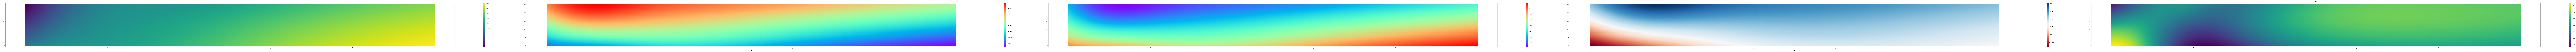

In [14]:
from PINNs import Visualization
import numpy as np
fig, axes = plt.subplots(1,5, figsize=(6*5*10,6))
s =80
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)
plt.tight_layout()
plt.show()

In [15]:
boundary_conditions_list[2].sampling_collocation_points(1000)
boundary_conditions_list[2].pde_define(NVS())
boundary_conditions_list[2].process_model(model2)
boundary_conditions_list[2].process_pde()
X,Y,T = boundary_conditions_list[2].model_inputs.values()
U,V,P = boundary_conditions_list[2].model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

In [16]:
print(Y.shape)

(1000, 1)


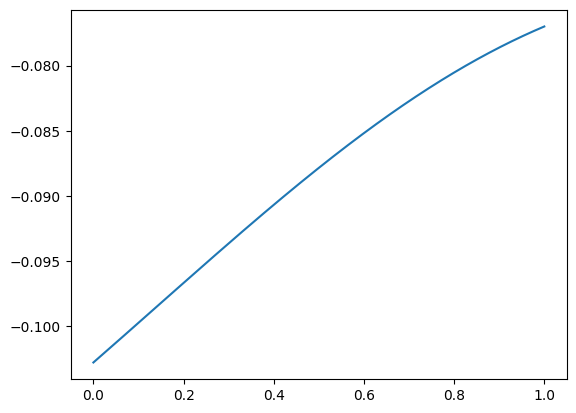

In [17]:
plt.plot(Y.flatten(), U.flatten())
plt.show()

In [18]:
fig.savefig('channel_flow_steady.png')